In [6]:
import torch
import torch.nn as nn
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
#from sklearn.model_selection import train_test_split

In [2]:
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        
        self.input_w = nn.Sequential(*[
                        nn.Linear(1, 1,bias=False),
                        nn.ReLU()])
        
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN+1, N_HIDDEN+1),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN+1, N_OUTPUT)
        
  
    def forward(self, x):
        x1 = self.fcs(x)
        x2 = self.input_w(torch.Tensor([1]))
        x = torch.cat((x1,torch.ones(len(x1),1)*x2), dim=1)
        x = self.fch(x)
        x = self.fce(x)
        
        return x  

In [3]:
def osc_harm(t,a,w,phi):
    return(a*np.cos(w*t+phi))

omega = 0.5
k = 1
m = 4

x = torch.linspace(0,8*np.pi,500).view(-1,1)
y = osc_harm(x,2,omega,0)

x_train = x[0:400:20]
y_train = y[0:400:20]

x_grad = torch.linspace(0,8*np.pi,50).view(-1,1).requires_grad_(True)
y_grad = osc_harm(x,2,omega,0)


 epoch 16281 losstensor(9.5747e-05, grad_fn=<AddBackward0>)

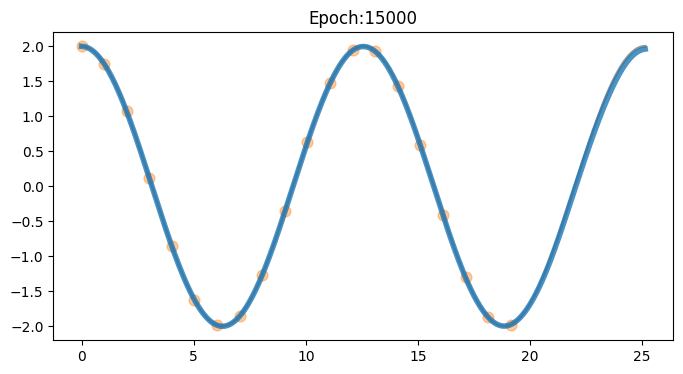

In [21]:
def plot_result(x,y,x_data,y_data,yh,epoch):
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    plt.title("Epoch:"+str(epoch*1000))
    
    plt.savefig(path_to_plots_temp+"/plot_epoch_"+str(epoch+1))
    
def delete_temp_plots(path):
    for file in os.listdir(path):
        os.remove(path+"/"+file)

path_to_plots_temp = ""


def osc_harm(input,t):    
    return(input[0]*torch.cos(input[1]*t+input[2])) 
         
# train standard neural network to fit training data
delete_temp_plots(path_to_plots_temp)
torch.manual_seed(123)
model = FCN(1,1,10,4)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)
files = []

for i in range(50000):
    
    optimizer.zero_grad()
    
    # Regular neural network model
    yh = model(x_train)
    loss_1 = torch.mean((yh -y_train)**2)# use mean squared error
    
    # PPI model
    yhp = model(x_grad)
       
    dx  = torch.autograd.grad(yhp, x_grad, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_grad, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + ((list(model.parameters())[0])/m)*yhp # computes harmonic oscilator equation
    
    loss_2 = torch.mean(physics**2) # Loss of PPI model
    
    loss = 1.5*loss_1 +0.5*loss_2 # combine losses from two models
    
    sys.stdout.write("\r epoch "+str(i)+" loss"+str(loss))
    
    #if (loss < 0.02):
    #    optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
    
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 1000 == 0: 
        plt.close()
        yh = model(x).detach()   
        plot_result(x,y,x_train,y_train,yh,i//1000)
    if (loss.detach().numpy()<0.0001):
        break
        

        

In [22]:


frames = []
for t in range(len(os.listdir(path_to_plots_temp))-1):
    image = imageio.v2.imread(path_to_plots_temp+"/plot_epoch_"+str(t+1)+".png")
    frames.append(image)
    
imageio.mimsave(path_to_plots_temp+'/Plot.gif', # output gif   
                frames,
                format = "GIF",# array of input frames
                duration = 0.25) 